<h1>Zomato Bangalore Restaurants<span class="tocSkip"></span></h1>

<h2>Business Case<span class="tocSkip"></span></h2>
The third most populous city in India, Bangalore, boasts a diverse array of restaurants representing global cuisines, making it a culinary haven for food enthusiasts. Over the recent years, the city has witnessed a notable surge in the number of dining establishments, presenting a challenge in selecting an exceptional dining venue.

The objective of this endeavor is to discern the key attributes that define a remarkable restaurant and to develop a restaurant recommender system. This system aims to simplify the process of choosing the perfect dining destination, offering a more streamlined and informed decision-making experience for patrons.
> dataset: https://www.kaggle.com/himanshupoddar/zomato-bangalore-restaurants

## Import the libraries and data

In [1]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
zomato = pd.read_csv('/Data/zomato.csv', delimiter=',')

In [3]:
ratings = pd.read_csv('/Data/ratings.csv', index_col=0)

In [4]:
locations = pd.read_csv('/Data/locations.csv')

## EDA and cleaning the data

### Locations:

In [5]:
locations.head()

Name                         geo_loc
0        Bangalore Banashankari         (12.9152208, 77.573598)
1        Bangalore Basavanagudi        (12.9417261, 77.5755021)
2         Bangalore Mysore Road        (12.9314092, 77.5067138)
3           Bangalore Jayanagar        (12.9292731, 77.5824229)
4  Bangalore Kumaraswamy Layout  (12.9068169, 77.5635247362134)

In [6]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     94 non-null     object
 1   geo_loc  88 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


In [7]:
locations.isna().sum()

Name       0
geo_loc    6
dtype: int64

In [8]:
#dropping NaN:

locations.dropna(inplace=True)

In [9]:
locations.duplicated().sum()

0

In [10]:
locations2 = locations.copy()

### Ratings:

In [11]:
ratings.head()

name  rating                                             review
0  Jalsa     4.0  A beautiful place to dine inThe interiors take...
1  Jalsa     4.0  I was here for dinner with my family on a week...
2  Jalsa     2.0  Its a restaurant near to Banashankari BDA Me a...
3  Jalsa     4.0  We went here on a weekend and one of us had th...
4  Jalsa     5.0  The best thing about the place is its ambiance...

In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319968 entries, 0 to 1319967
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   name    1319968 non-null  object 
 1   rating  1319968 non-null  float64
 2   review  1316924 non-null  object 
dtypes: float64(1), object(2)
memory usage: 40.3+ MB


In [13]:
ratings.duplicated().sum()

1187641

In [14]:
ratings.drop_duplicates(inplace=True)

In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132327 entries, 0 to 1317826
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    132327 non-null  object 
 1   rating  132327 non-null  float64
 2   review  131605 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.0+ MB


In [16]:
ratings2 = ratings.copy()

### Zomato:

In [17]:
zomato.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

In [18]:
# renaming columns:

zomato.rename(columns={'approx_cost(for two people)': 'avg_cost', 'listed_in(type)': 'listed_type', 'listed_in(city)': 'listed_city','reviews_list': 'reviews'}, inplace=True) 

In [19]:
zomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           51717 non-null  object
 1   address       51717 non-null  object
 2   name          51717 non-null  object
 3   online_order  51717 non-null  object
 4   book_table    51717 non-null  object
 5   rate          43942 non-null  object
 6   votes         51717 non-null  int64 
 7   phone         50509 non-null  object
 8   location      51696 non-null  object
 9   rest_type     51490 non-null  object
 10  dish_liked    23639 non-null  object
 11  cuisines      51672 non-null  object
 12  avg_cost      51371 non-null  object
 13  reviews       51717 non-null  object
 14  menu_item     51717 non-null  object
 15  listed_type   51717 non-null  object
 16  listed_city   51717 non-null  object
dtypes: int64(1), object(16)
memory usage: 6.7+ MB


In [20]:
#zomato: dropping columns:

zomato = zomato.drop(['url', 'address', 'phone'], axis = 1)

In [21]:
# rate column: remove /5

zomato['rate'] = zomato['rate'].str.rstrip('/5')

In [22]:
zomato.rate.value_counts()

NEW     2208
3.9     2098
3.8     2022
3.7     2011
3.9     1874
        ... 
2.2        7
2.0        7
2.0        4
1.8        3
1.8        2
Name: rate, Length: 64, dtype: int64

In [23]:
# Changing "NEW" value in rate column to NaN and dropping all NaNs in that column and
# transforming rate to float:

zomato['rate'] = zomato.rate.replace("NEW", np.nan)
zomato['rate'] = zomato.rate.replace("-", np.nan)

In [24]:
zomato.rate.unique()

#drop nans:
zomato.dropna(subset=['rate'], how='all', inplace=True)

zomato = zomato.astype({'rate' : float})

In [25]:
print("The total number of restaurants: ", len(zomato['name'].unique()))

The total number of restaurants:  6649


In [26]:
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41665 entries, 0 to 51716
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          41665 non-null  object 
 1   online_order  41665 non-null  object 
 2   book_table    41665 non-null  object 
 3   rate          41665 non-null  float64
 4   votes         41665 non-null  int64  
 5   location      41665 non-null  object 
 6   rest_type     41516 non-null  object 
 7   dish_liked    23462 non-null  object 
 8   cuisines      41654 non-null  object 
 9   avg_cost      41418 non-null  object 
 10  reviews       41665 non-null  object 
 11  menu_item     41665 non-null  object 
 12  listed_type   41665 non-null  object 
 13  listed_city   41665 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 4.8+ MB


In [27]:
zomato.isna().sum()

name                0
online_order        0
book_table          0
rate                0
votes               0
location            0
rest_type         149
dish_liked      18203
cuisines           11
avg_cost          247
reviews             0
menu_item           0
listed_type         0
listed_city         0
dtype: int64

In [28]:
# dropping NaNs of some other variables:
zomato.dropna(subset=['avg_cost'], how='all', inplace=True)

zomato.dropna(subset=['rest_type'], how='all', inplace=True)

zomato.dropna(subset=['cuisines'], how='all', inplace=True)


In [29]:
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41263 entries, 0 to 51716
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          41263 non-null  object 
 1   online_order  41263 non-null  object 
 2   book_table    41263 non-null  object 
 3   rate          41263 non-null  float64
 4   votes         41263 non-null  int64  
 5   location      41263 non-null  object 
 6   rest_type     41263 non-null  object 
 7   dish_liked    23259 non-null  object 
 8   cuisines      41263 non-null  object 
 9   avg_cost      41263 non-null  object 
 10  reviews       41263 non-null  object 
 11  menu_item     41263 non-null  object 
 12  listed_type   41263 non-null  object 
 13  listed_city   41263 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 4.7+ MB


In [30]:
zomato['online_order'].value_counts()

Yes    27102
No     14161
Name: online_order, dtype: int64

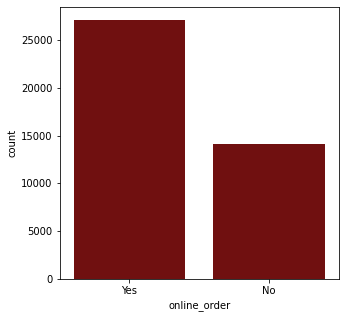

In [31]:
plt.figure(figsize = (5, 5))
sns.countplot(zomato['online_order'], color = 'maroon');

In [32]:
# there are no strange values in online order column, we can encode it to 0s and 1s:
zomato['online_order'].replace({'Yes' : 1, 'No' : 0}, inplace = True)

In [33]:
zomato['book_table'].value_counts()

No     34959
Yes     6304
Name: book_table, dtype: int64

In [34]:
zomato['book_table'].replace({'Yes' : 1, 'No' : 0}, inplace = True)

In [35]:
zomato['avg_cost'].unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1,200', '350', '250',
       '950', '1,000', '1,500', '1,300', '199', '1,100', '1,600', '230',
       '130', '1,700', '1,350', '2,200', '1,400', '2,000', '1,800',
       '1,900', '180', '330', '2,500', '2,100', '3,000', '2,800', '3,400',
       '50', '40', '1,250', '3,500', '4,000', '2,400', '2,600', '1,450',
       '70', '3,200', '240', '6,000', '1,050', '2,300', '4,100', '120',
       '5,000', '3,700', '1,650', '2,700', '4,500', '80'], dtype=object)

In [36]:
zomato.duplicated().sum()

37

In [37]:
zomato.drop_duplicates(inplace=True)

In [38]:
zomato['avg_cost'] = zomato['avg_cost'].astype(str)
zomato['avg_cost'] = zomato['avg_cost'].apply(lambda x: x.replace(',',''))
zomato['avg_cost'] = zomato['avg_cost'].astype(float)

In [39]:
zomato.head()

name  online_order  book_table  rate  votes      location  \
0                  Jalsa             1           1   4.1    775  Banashankari   
1         Spice Elephant             1           0   4.1    787  Banashankari   
2        San Churro Cafe             1           0   3.8    918  Banashankari   
3  Addhuri Udupi Bhojana             0           0   3.7     88  Banashankari   
4          Grand Village             0           0   3.8    166  Basavanagudi   

             rest_type                                         dish_liked  \
0        Casual Dining  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1        Casual Dining  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Cafe, Casual Dining  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3          Quick Bites                                        Masala Dosa   
4        Casual Dining                                Panipuri, Gol Gappe   

                         cuisines  avg_cost  \
0  North Indian, Mughlai, Chinese     800.0   
1     Chinese, North Indian, Thai     800.0   
2          Cafe, Mexican, Italian     800.0   
3      South Indian, North Indian     300.0   
4        North Indian, Rajasthani     600.0   

                                             reviews menu_item listed_type  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []      Buffet   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []      Buffet   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []      Buffet   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []      Buffet   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []      Buffet   

    listed_city  
0  Banashankari  
1  Banashankari  
2  Banashankari  
3  Banashankari  
4  Banashankari

In [40]:
zomato.location.unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Bannerghatta Road', 'BTM', 'Kanakapura Road', 'Bommanahalli',
       'Electronic City', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Richmond Road', 'HSR',
       'Koramangala 7th Block', 'Bellandur', 'Sarjapur Road',
       'Marathahalli', 'Whitefield', 'East Bangalore', 'Old Airport Road',
       'Indiranagar', 'Koramangala 1st Block', 'Frazer Town', 'MG Road',
       'Brigade Road', 'Lavelle Road', 'Church Street', 'Ulsoor',
       'Residency Road', 'Shivajinagar', 'Infantry Road',
       'St. Marks Road', 'Cunningham Road', 'Race Course Road',
       'Commercial Street', 'Vasanth Nagar', 'Domlur',
       'Koramangala 8th Block', 'Ejipura', 'Jeevan Bhima Nagar',
       'Old Madras Road', 'Seshadripuram', 'Kammanahalli',
       'Koramangala 6th Block', 'Ma

In [41]:
zomato['listed_city'].unique()

array(['Banashankari', 'Bannerghatta Road', 'Basavanagudi', 'Bellandur',
       'Brigade Road', 'Brookefield', 'BTM', 'Church Street',
       'Electronic City', 'Frazer Town', 'HSR', 'Indiranagar',
       'Jayanagar', 'JP Nagar', 'Kalyan Nagar', 'Kammanahalli',
       'Koramangala 4th Block', 'Koramangala 5th Block',
       'Koramangala 6th Block', 'Koramangala 7th Block', 'Lavelle Road',
       'Malleshwaram', 'Marathahalli', 'MG Road', 'New BEL Road',
       'Old Airport Road', 'Rajajinagar', 'Residency Road',
       'Sarjapur Road', 'Whitefield'], dtype=object)

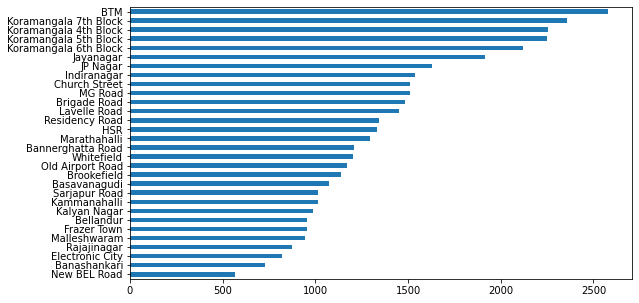

In [42]:
ax = zomato['listed_city'].value_counts().sort_values().plot(kind='barh', figsize=(9,5));

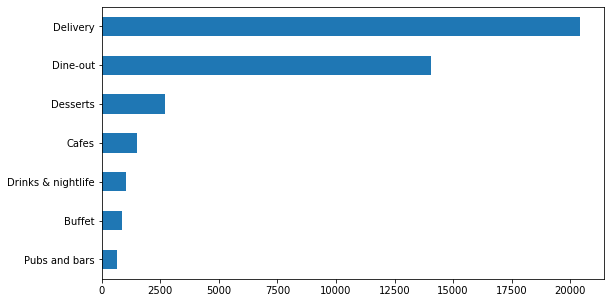

In [43]:
ax = zomato['listed_type'].value_counts().sort_values().plot(kind='barh', figsize=(9,5));

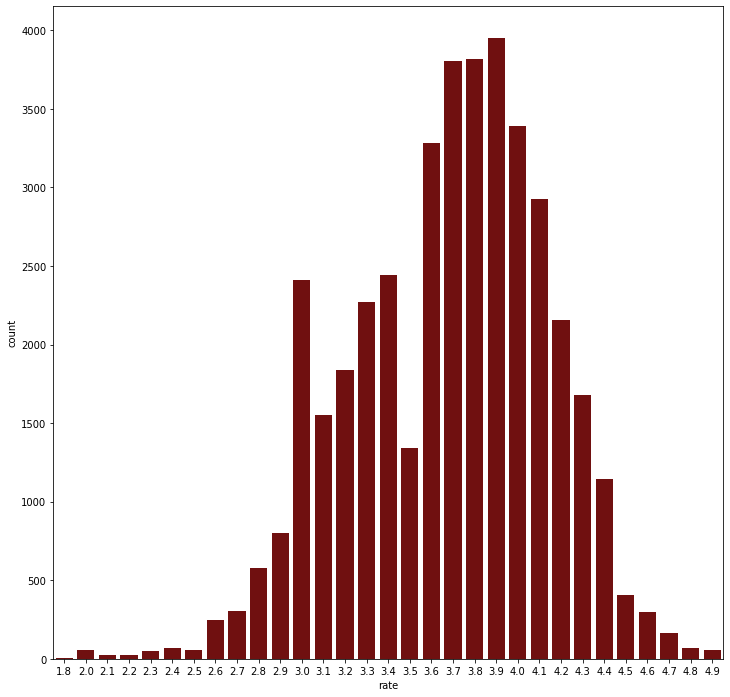

In [44]:
plt.figure(figsize = (12, 12))
sns.countplot(zomato['rate'], color = 'maroon');

In [45]:
#. Name Variable:


# the total number of unique restaurants:

zomato.name.nunique()

6602

In [46]:
#are there many chains among our restaurants? Which ones are the most common?

Text(0.5, 1.0, 'Most common restaurants')

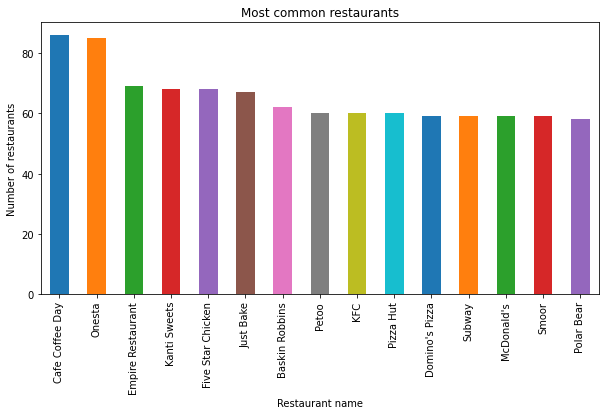

In [47]:
#colors = ['aliceblue',  'aqua', 'aquamarine', 'darkturquoise']
col_palet = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]


plt.figure(figsize = (10,5))
ax = zomato.name.value_counts()[:15].plot(kind = 'bar', color=col_palet)
plt.xlabel("Restaurant name")
plt.ylabel("Number of restaurants")
plt.title("Most common restaurants")

In [48]:
# Let's check the top rated restaurants and see if chains that we see above are among them:

In [49]:
top_rated_df = pd.DataFrame(zomato.groupby('name')['rate'].mean().sort_values(ascending = False))
top_rated_df[:15]

rate
name                                                        
Asia Kitchen By Mainland China                      4.900000
SantÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ...  4.900000
Byg Brewski Brewing Company                         4.900000
Punjab Grill                                        4.871429
Belgian Waffle Factory                              4.844828
The Pizza Bakery                                    4.800000
O.G. Variar & Sons                                  4.800000
Flechazo                                            4.800000
AB's - Absolute Barbecues                           4.789474
Biergarten                                          4.766667
CTR                                                 4.750000
Barbecue by Punjab Grill                            4.750000
The Black Pearl                                     4.727778
House Of Commons                                    4.723810
Taaza Thindi                                        4.700000

In [50]:
# None of the top chains appears on the list above. The list above doesn't take into 
#consideration the number of votes.

In [51]:
top_rated_votes = pd.DataFrame(zomato.groupby('name')['rate', 'votes'].max().sort_values(by = 'votes', ascending = False))

top_rated_votes[:15]

rate  votes
name                                    
Byg Brewski Brewing Company   4.9  16832
Toit                          4.7  14956
Truffles                      4.7  14726
AB's - Absolute Barbecues     4.9  12121
The Black Pearl               4.8  10550
Big Pitcher                   4.7   9300
Onesta                        4.6   9085
Arbor Brewing Company         4.5   8419
Empire Restaurant             4.4   8304
Prost Brew Pub                4.5   7871
Church Street Social          4.3   7584
Hoot                          4.2   7330
Barbeque Nation               4.8   7270
Meghana Foods                 4.5   7238
Flechazo                      4.9   7154

In [52]:
#The clear winner seems to be Byg Brewski Brewing Company, it has the highest amount of votes 
#and a super high rating

In [53]:
#What about the average cost? 

average_cost = pd.DataFrame(zomato.groupby('name')['avg_cost'].mean().sort_values(ascending = False))

average_cost[:20]

avg_cost
name                                                        
Le Cirque Signature - The Leela Palace                6000.0
Royal Afghan - ITC Windsor                            5000.0
Malties - Radisson Blu                                4500.0
La Brasserie - Le Meridien                            4100.0
Grill 99 - The Ritz-Carlton                           4000.0
Masala Klub - The Taj West End                        4000.0
Alba - JW Marriott Bengaluru                          4000.0
Dum Pukht Jolly Nabobs - ITC Windsor                  4000.0
Jamavar - The Leela Palace                            4000.0
Edo Restaurant & Bar - ITC Gardenia                   4000.0
Riwaz - The Ritz-Carlton                              4000.0
Dakshin - ITC Windsor                                 4000.0
Baluchi - The Lalit Ashok Bangalore                   3700.0
Kebabs & Kurries - ITC Gardenia                       3500.0
Zen - The Leela Palace                                3500.0
The Lantern Restaurant & Bar - The Ritz-Carlton...    3500.0
Karavalli - The Gateway Hotel                         3500.0
Citrus - The Leela Palace                             3500.0
The Market - The Ritz-Carlton                         3400.0
b CafÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃ...    3400.0

In [54]:
zomato['avg_cost'] = zomato['avg_cost'].apply(np.int64)

In [55]:
#do the most expensive restaurants also have the highest ratings?

average_cost_rate = pd.DataFrame(zomato.groupby('name')['rate','avg_cost'].mean().sort_values(by='rate' ,ascending = False))

average_cost_rate[:20]

rate     avg_cost
name                                                                     
Asia Kitchen By Mainland China                      4.900000  1500.000000
SantÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ...  4.900000  1000.000000
Byg Brewski Brewing Company                         4.900000  1600.000000
Punjab Grill                                        4.871429  2000.000000
Belgian Waffle Factory                              4.844828   400.000000
The Pizza Bakery                                    4.800000  1200.000000
O.G. Variar & Sons                                  4.800000   200.000000
Flechazo                                            4.800000  1400.000000
AB's - Absolute Barbecues                           4.789474  1568.421053
Biergarten                                          4.766667  2200.000000
CTR                                                 4.750000   150.000000
Barbecue by Punjab Grill                            4.750000  1300.000000
The Black Pearl                                     4.727778  1427.777778
House Of Commons                                    4.723810  1000.000000
Taaza Thindi                                        4.700000   100.000000
Maziga                                              4.700000  1500.000000
TBC Sky Lounge                                      4.700000  1000.000000
Toit                                                4.700000  1500.000000
The Big Barbeque                                    4.700000  1500.000000
ECHOES Koramangala                                  4.700000   750.000000

In [56]:
zomato2 = zomato.copy()

## Ratings: NLP analysis

In [57]:
import sys

sys.path.insert(0, '/Users/agieen/Downloads/AllWomen/_functions_')

from fx_NLP import *

In [58]:
import numpy as np
import re
import string

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from itertools import islice
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer

from bs4 import BeautifulSoup
import requests
import re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect

from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image



import json
from googletrans import Translator
from googleapiclient.discovery import build

In [59]:
#pd.set_option('display.max_colwidth', -1)
#ratings

In [60]:
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

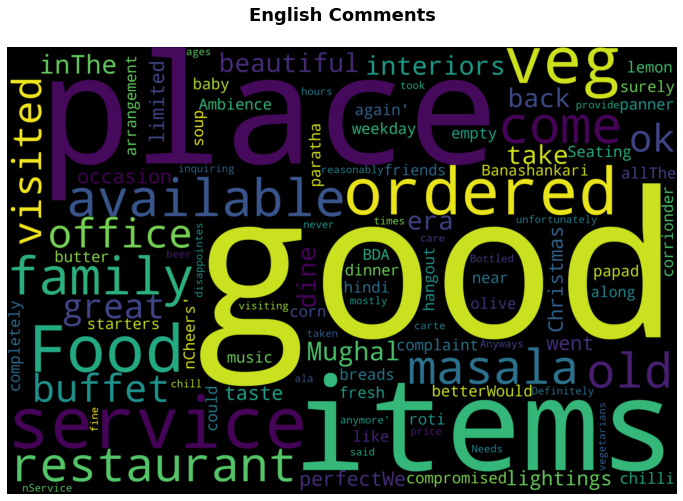

In [61]:
wordcloud = WordCloud(max_font_size=None, max_words=100, background_color="black", 
                      width=3000, height=2000,collocations=False,
                      stopwords = stopwords.words('english')).generate(str(ratings.review.values))

plot_wordcloud(wordcloud, 'English')

### Sentiment analysis - ratings

In [62]:
# load the SentimentIntensityAnalyser object in
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [63]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [64]:
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [65]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132327 entries, 0 to 1317826
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    132327 non-null  object 
 1   rating  132327 non-null  float64
 2   review  131605 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.0+ MB


In [66]:
ratings.dropna(inplace=True)

In [67]:
ratings['sentiment_neg'] = ratings['review'].apply(negative_score) 
ratings['sentiment_neu'] = ratings['review'].apply(neutral_score) 
ratings['sentiment_pos'] = ratings['review'].apply(positive_score) 
ratings['sentiment_compound'] = ratings['review'].apply(compound_score)





In [68]:
ratings.to_csv('Ratings_sentiment_India.csv')

In [69]:
ratings_s = pd.read_csv('/Users/agieen/Downloads/AllWomen/_biModule_projects_/Project 3/Ratings_sentiment_India.csv')

In [70]:
ratings_s.head()

Unnamed: 0   name  rating  \
0           0  Jalsa     4.0   
1           1  Jalsa     4.0   
2           2  Jalsa     2.0   
3           3  Jalsa     4.0   
4           4  Jalsa     5.0   

                                              review  sentiment_neg  \
0  A beautiful place to dine inThe interiors take...          0.062   
1  I was here for dinner with my family on a week...          0.027   
2  Its a restaurant near to Banashankari BDA Me a...          0.047   
3  We went here on a weekend and one of us had th...          0.000   
4  The best thing about the place is its ambiance...          0.000   

   sentiment_neu  sentiment_pos  sentiment_compound  
0          0.799          0.139              0.7430  
1          0.684          0.289              0.9623  
2          0.781          0.172              0.7964  
3          0.725          0.275              0.9678  
4          0.605          0.395              0.9702

In [71]:
ratings_s['sentiment_neg'].value_counts()

0.000    70719
0.037      638
0.030      628
0.036      626
0.027      623
         ...  
0.710        1
0.475        1
0.618        1
0.544        1
0.540        1
Name: sentiment_neg, Length: 695, dtype: int64

In [72]:
ratings_s['sentiment_pos'].value_counts()

0.000    17748
1.000     2155
0.744      687
0.167      477
0.182      441
         ...  
0.888        1
0.835        1
0.738        1
0.812        1
0.745        1
Name: sentiment_pos, Length: 790, dtype: int64

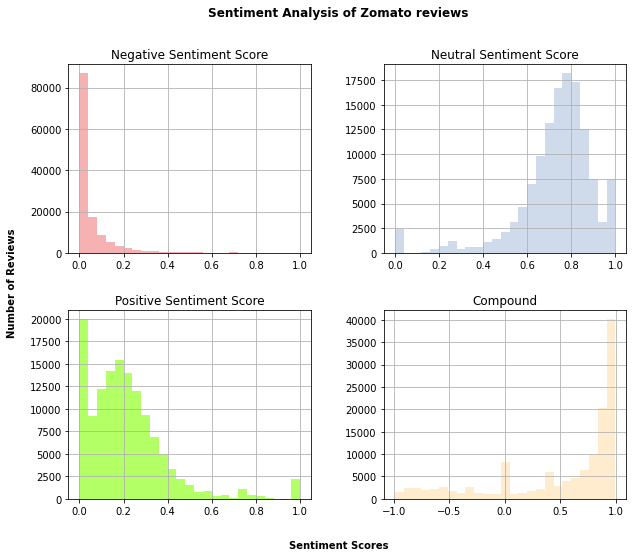

In [73]:
# all scores in 4 histograms
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
ratings_s.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')

ratings_s.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')

ratings_s.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')

ratings_s.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of Zomato reviews\n\n', fontsize=12, fontweight='bold');

In [74]:
percentiles = ratings_s.sentiment_compound.describe(percentiles=[.05,
                                                          .1, .2, .3, 
                                                          .4, .5, .6, 
                                                          .7, .8, .9])
percentiles

count    131605.000000
mean          0.511971
std           0.564792
min          -0.991100
5%           -0.743000
10%          -0.511800
20%           0.000000
30%           0.440220
40%           0.636900
50%           0.802000
60%           0.877900
70%           0.921000
80%           0.949300
90%           0.970900
max           0.998200
Name: sentiment_compound, dtype: float64

### Comparing Negative and Positive Comments


In [75]:
# full dataframe with POSITIVE comments
df_pos = ratings_s.loc[ratings_s.sentiment_compound >= 0.95]

# only corpus of POSITIVE comments
pos_comments = df_pos['review'].tolist()
pos_comments[:3]

['I was here for dinner with my family on a weekday The restaurant was completely empty Ambience is good with some good old hindi music Seating arrangement are good too We ordered masala papad panner and baby corn starters lemon and corrionder soup butter roti olive and chilli paratha Food was fresh and good service is good too Good for family hangout\nCheers',
 'We went here on a weekend and one of us had the buffet while two of us took Ala Carte Firstly the ambience and service of this place is great The buffet had a lot of items and the good was good We had a Pumpkin Halwa intm the dessert which was amazing Must try The kulchas are great here Cheers',
 'The best thing about the place is its ambiance Second best thing was yummy  food We try buffet and buffet food was not disappointed us\nTest      \nQuality  \nService Staff was very professional and friendly\n\nOverall experience was excellent\n\nsubirmajumder85wixsitecom']

In [76]:
# full dataframe with POSITIVE comments
df_neg = ratings_s.loc[ratings_s.sentiment_compound < 0.0]

# only corpus of POSITIVE comments
neg_comments = df_neg['review'].tolist()
neg_comments[:3]

['I had a very bad experience here\nI dont know about a la carte but the buffet was the worst They gave us complementary drink and momos before the buffet The momos were really good\nThe number of varieties first of all was very disappointing The service was very slow They refilled the food very slowly The starters were okay The main course also was so so There was two gravies with roti and some rice with raitha They had chats sev puri and pan puri which was average But the desert was disappointing They had gulab Jamun and chocolate cake The jamun was not cooked inside There was a cold blob of raw dough inside The chocolate cake also was really hard and not that good\nOverall the buffet was a bad experience for me',
 'Spice elephant soup SPL almost manchow flavour soup Just above medium spicy\n\nLasooni fish tikka was awesome\n\nI dont remember the dessert name but I have attached the photo  It had vanilla ice inside wafers Wafer was hell hard egg smell chewy  Nightmare dessert \n\nTab

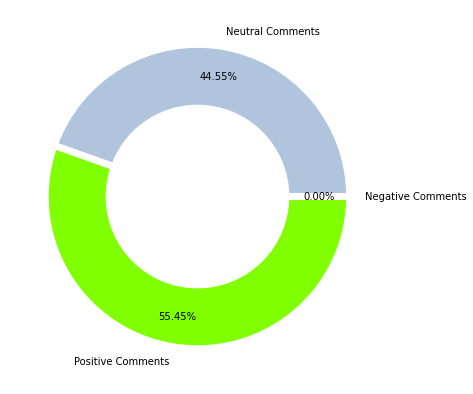

In [77]:
# assign the data
neg = percentiles['20%']
mid = percentiles['50%']
pos = percentiles['max']
names = ['Negative Comments', 'Neutral Comments','Positive Comments']

size = [neg, mid, pos]

# call a pie chart
plt.pie(size, labels=names, colors=['lightcoral', 'lightsteelblue', 'chartreuse'], 
        autopct='%.2f%%', pctdistance=0.8,
        wedgeprops={'linewidth':7, 'edgecolor':'white' })

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.show()

### comparing the length of both positive and negative comments

In [78]:
df_pos['text_length'] = df_pos['review'].apply(len)
df_neg['text_length'] = df_neg['review'].apply(len)

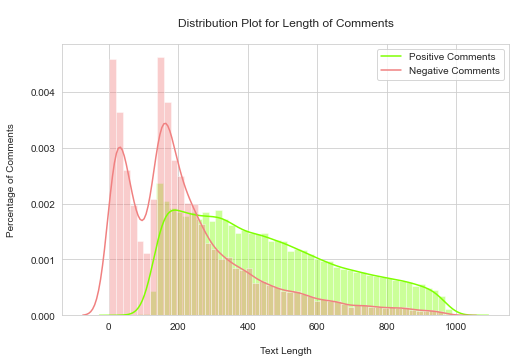

In [79]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df_pos['text_length'], kde=True, bins=50, color='chartreuse')
sns.distplot(df_neg['text_length'], kde=True, bins=50, color='lightcoral')

plt.title('\nDistribution Plot for Length of Comments\n')
plt.legend(['Positive Comments', 'Negative Comments'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');

In [80]:
# It looks like there are more lengthy positive comments than negative ones

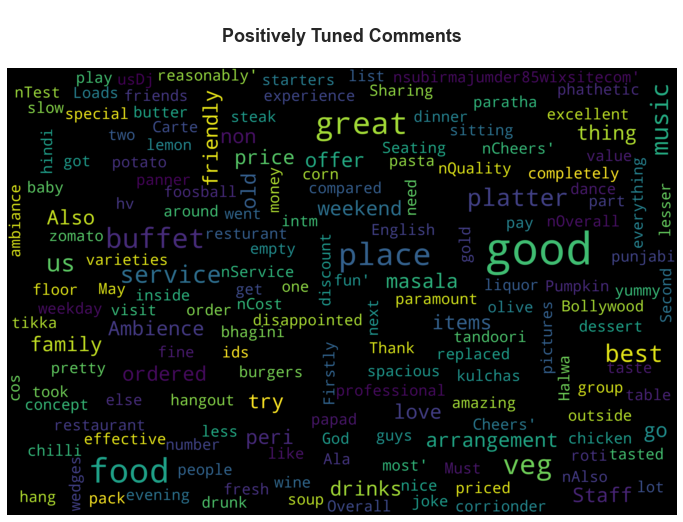

In [81]:
wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="black",
                      width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(df_pos.review.values))

plot_wordcloud(wordcloud, '\nPositively Tuned')

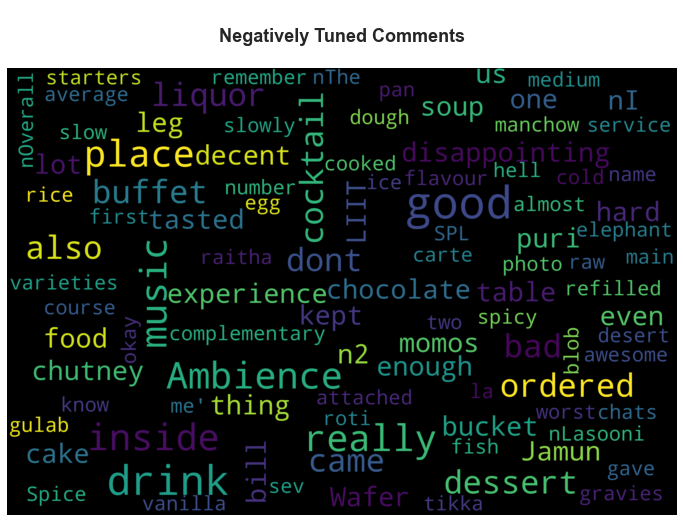

In [82]:
wordcloud = WordCloud(max_font_size=200, max_words=100, background_color="black",
                      width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(df_neg.review.values))

plot_wordcloud(wordcloud, '\nNegatively Tuned')

## Ratings - Topic modelling - Genism

In [83]:
ratings3 = ratings2.copy()

In [84]:
ratings2.head()

name  rating                                             review
0  Jalsa     4.0  A beautiful place to dine inThe interiors take...
1  Jalsa     4.0  I was here for dinner with my family on a week...
2  Jalsa     2.0  Its a restaurant near to Banashankari BDA Me a...
3  Jalsa     4.0  We went here on a weekend and one of us had th...
4  Jalsa     5.0  The best thing about the place is its ambiance...

In [85]:
ratings2.dropna(inplace=True)

In [86]:
ratings2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131605 entries, 0 to 1317826
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    131605 non-null  object 
 1   rating  131605 non-null  float64
 2   review  131605 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.0+ MB


In [87]:
## Data preprocessing
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation) 
lemmatize = WordNetLemmatizer()

In [88]:
def cleaning(article):
    one = " ".join([i for i in article.lower().split() if i not in stopwords])
    two = "".join(i for i in one if i not in punctuation)
    three = " ".join(lemmatize.lemmatize(i) for i in two.split())
    return three

In [89]:
text = ratings2['review'].apply(lambda x: cleaning(x))

In [90]:
text

0          beautiful place dine inthe interior take back ...
1          dinner family weekday restaurant completely em...
2          restaurant near banashankari bda along office ...
3          went weekend one u buffet two u took ala carte...
4          best thing place ambiance second best thing yu...
                                 ...                        
1317583    food guess happy lively good music ambience re...
1317584    today evening visited place best thing service...
1317824    fine place chill office hour reasonably good p...
1317825    thank god bhagini replaced old phathetic param...
1317826    decent place havent tried andhra meal yet regu...
Name: review, Length: 131605, dtype: object

In [91]:
# split the text to tokens:

text_list = [i.split() for i in text]
len(text_list)

    

131605

In [92]:
import gensim
from gensim import corpora

In [93]:
# Build and save a dictrionary:

dictionary = corpora.Dictionary(text_list)
dictionary.save('dictionary.dict')
print(dictionary)

Dictionary(89311 unique tokens: ['allthe', 'available', 'back', 'beautiful', 'betterwould']...)


In [94]:
text_list[:2]

[['beautiful',
  'place',
  'dine',
  'inthe',
  'interior',
  'take',
  'back',
  'mughal',
  'era',
  'lighting',
  'perfectwe',
  'went',
  'occasion',
  'christmas',
  'limited',
  'item',
  'available',
  'taste',
  'service',
  'compromised',
  'allthe',
  'complaint',
  'bread',
  'could',
  'betterwould',
  'surely',
  'like',
  'come'],
 ['dinner',
  'family',
  'weekday',
  'restaurant',
  'completely',
  'empty',
  'ambience',
  'good',
  'good',
  'old',
  'hindi',
  'music',
  'seating',
  'arrangement',
  'good',
  'ordered',
  'masala',
  'papad',
  'panner',
  'baby',
  'corn',
  'starter',
  'lemon',
  'corrionder',
  'soup',
  'butter',
  'roti',
  'olive',
  'chilli',
  'paratha',
  'food',
  'fresh',
  'good',
  'service',
  'good',
  'good',
  'family',
  'hangout',
  'cheer']]

In [95]:
#doc2bow:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]



In [96]:
doc_term_matrix[:2]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1)],
 [(23, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 2),
  (40, 1),
  (41, 1),
  (42, 6),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1)]]

In [97]:
corpora.MmCorpus.serialize('corpus_s.mm', doc_term_matrix)

print (len(doc_term_matrix))
print (doc_term_matrix[100])

131605
[(5, 1), (15, 1), (17, 1), (40, 2), (46, 1), (70, 1), (82, 1), (96, 1), (105, 1), (107, 1), (152, 1), (197, 1), (233, 1), (237, 1), (243, 1), (265, 2), (273, 1), (295, 1), (307, 1), (348, 2), (352, 1), (413, 1), (444, 1), (518, 2), (569, 2), (605, 1), (648, 1), (876, 1), (980, 1), (1127, 1), (1133, 1), (1136, 1), (1217, 1), (1218, 1), (1219, 1), (1220, 1), (1221, 1), (1222, 1), (1223, 1), (1224, 1), (1225, 1), (1226, 1), (1227, 1), (1228, 1), (1229, 3), (1230, 1), (1231, 1), (1232, 1)]


### LDA model

In [98]:
lda = gensim.models.ldamodel.LdaModel

ldamodel = lda(doc_term_matrix, num_topics=10, id2word=dictionary,
              passes=50)

In [99]:
for i in ldamodel.print_topics():
    for j in i:
        print(j)

0
0.120*"pizza" + 0.094*"cake" + 0.049*"burger" + 0.038*"cheese" + 0.023*"sandwich" + 0.021*"ordered" + 0.020*"bread" + 0.018*"mouth" + 0.018*"pastry" + 0.013*"fresh"
1
0.062*"place" + 0.033*"good" + 0.019*"food" + 0.014*"ambience" + 0.012*"service" + 0.010*"nice" + 0.009*"great" + 0.008*"one" + 0.008*"drink" + 0.008*"beer"
2
0.044*"place" + 0.021*"best" + 0.021*"one" + 0.019*"food" + 0.019*"try" + 0.015*"time" + 0.014*"must" + 0.014*"love" + 0.014*"visit" + 0.013*"amazing"
3
0.038*"food" + 0.030*"order" + 0.018*"bad" + 0.017*"time" + 0.016*"ordered" + 0.015*"dont" + 0.015*"delivery" + 0.014*"restaurant" + 0.012*"even" + 0.012*"worst"
4
0.101*"good" + 0.093*"food" + 0.043*"service" + 0.028*"taste" + 0.026*"place" + 0.021*"nice" + 0.020*"ambience" + 0.020*"quality" + 0.019*"price" + 0.019*"really"
5
0.099*"chicken" + 0.076*"biryani" + 0.036*"rice" + 0.035*"good" + 0.033*"ordered" + 0.032*"biriyani" + 0.030*"taste" + 0.026*"quantity" + 0.019*"piece" + 0.018*"mutton"
6
0.031*"chicken" + 0

In [100]:
# saving the topic:
ldamodel.save('reviews_topics.model')

In [101]:
# loading the saved model:

from gensim.models import LdaModel
model_loaded = LdaModel.load('reviews_topics.model')

In [102]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [103]:
#dictionary.filter_extremes(no_below=2, no_above=1.0)



/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
#saving all the info from above into new variables:

d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus_s.mm')
lda = gensim.models.LdaModel.load('reviews_topics.model')

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Restaurant Recommender

In [108]:
# Random sampling of the dataframe

df_percent = zomato.sample(frac=1.0)

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
df_percent.set_index('name', inplace=True)


/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
indices = pd.Series(df_percent.index)


/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')  #bygrams
tfidf_matrix = tfidf.fit_transform(df_percent['reviews'])

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
from sklearn.metrics.pairwise import linear_kernel

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)


/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
cosine_similarities.shape


/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(41226, 41226)

In [114]:
df_cos = pd.DataFrame(cosine_similarities)


/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
df_cos.head()

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0         1         2         3         4         5         6      \
0  1.000000  0.000845  0.897962  0.000798  0.000973  0.938899  0.001575   
1  0.000845  1.000000  0.009177  0.005776  0.012723  0.001727  0.024919   
2  0.897962  0.009177  1.000000  0.008752  0.007581  0.866256  0.018086   
3  0.000798  0.005776  0.008752  1.000000  0.018566  0.002224  0.018097   
4  0.000973  0.012723  0.007581  0.018566  1.000000  0.001736  0.020169   

      7         8         9      ...     41216     41217     41218     41219  \
0  0.000851  0.002768  0.001280  ...  0.001122  0.132109  0.012911  0.001419   
1  0.006087  0.017486  0.009870  ...  0.010568  0.024250  0.031296  0.020994   
2  0.006991  0.017630  0.008882  ...  0.013090  0.135733  0.033259  0.010677   
3  0.008366  0.023115  0.014348  ...  0.009136  0.013212  0.032492  0.088436   
4  0.004570  0.022032  0.015027  ...  0.014752  0.017504  0.037923  0.015701   

      41220     41221     41222     41223     41224     41225  
0  0.001327  0.285834  0.053396  0.001995  0.002072  0.001355  
1  0.010322  0.014300  0.021904  0.032668  0.009722  0.006813  
2  0.008847  0.277924  0.065773  0.020167  0.008303  0.006891  
3  0.017678  0.016944  0.016665  0.035263  0.014876  0.013317  
4  0.023840  0.015073  0.023612  0.026004  0.010354  0.016201  

[5 rows x 41226 columns]

In [116]:
df_concatinated = pd.concat(
    [
        df_cos.reset_index(drop=True),
        zomato.reset_index(drop=True),
    ],
    axis=1,
    ignore_index=True,
)

df_concatinated_columns = [
    list(df_cos.columns),
    list(zomato.columns),
]
    
flatten = lambda nested_lists: [item for sublist in nested_lists for item in sublist]

df_concatinated.columns = flatten(df_concatinated_columns)

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [117]:
def filter_by(df, cuisines, rate):
    df_outcome = df
    if cuisines:
        df_outcome = df_outcome[df_outcome['cuisines'].str.contains(cuisines)]
    if rate:
        df_outcome = df_outcome[df_outcome['rate']>=rate]
  
    return df_outcome

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
def recommend(name, df_concatinated, cuisines = None, rate = None, cosine_similarities = cosine_similarities ):
    
    # An empty list to add top restaurants
    restaurant_recom = []
    
    # Find the index of the restaurant
    idx = indices[indices == name].index[0]
    
    # Find restaurants with similar cosine-sim value, sort from the biggest value
    scores = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Select top 20 restaurant indices with a similar cosine-similarity value
    indices_top20 = list(scores.iloc[0:21].index)
    
    # Extract the top restaurant names
    for item in indices_top20:
        restaurant_recom.append(list(df_percent.index)[item])
    
    # create a df to extract similar restaurants
    df_new = pd.DataFrame(columns=['cuisines', 'rate', 'avg_cost'])
    
    for item in  restaurant_recom:
        df_new = df_new.append(pd.DataFrame(df_percent[['cuisines', 'rate', 'avg_cost']][df_percent.index == item].sample()))
    
    # Drop duplicated restaurants and sort by rating
    df_new = df_new.drop_duplicates(subset=['cuisines', 'rate', 'avg_cost'], keep=False)
    df_new = df_new.sort_values(by='rate', ascending=False).head(10)
    
    print('Top Restaurants similar to %s: ' % (name))

    return filter_by(df_new,cuisines,rate)

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [126]:
recommend('Jalsa', df_concatinated, 'North Indian', 4.5)


/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top Restaurants similar to Jalsa: 


cuisines  \
Brew and Barbeque - A Microbrewery Pub  Continental, North Indian, BBQ, Steak   
Brew and Barbeque - A Microbrewery Pub  Continental, North Indian, BBQ, Steak   

                                        rate avg_cost  
Brew and Barbeque - A Microbrewery Pub   4.7     1400  
Brew and Barbeque - A Microbrewery Pub   4.6     1400

## Locations - map

In [130]:
locations['short_name'] = locations.Name.str.replace('Bangalore ', '')
locations

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Name                         geo_loc  \
0         Bangalore Banashankari         (12.9152208, 77.573598)   
1         Bangalore Basavanagudi        (12.9417261, 77.5755021)   
2          Bangalore Mysore Road        (12.9314092, 77.5067138)   
3            Bangalore Jayanagar        (12.9292731, 77.5824229)   
4   Bangalore Kumaraswamy Layout  (12.9068169, 77.5635247362134)   
..                           ...                             ...   
89      Bangalore West Bangalore        (12.9791198, 77.5912997)   
90         Bangalore Magadi Road         (12.9858515, 77.486927)   
91           Bangalore Yelahanka        (13.1006982, 77.5963454)   
92      Bangalore Sahakara Nagar   (13.0621474, 77.580061354805)   
93              Bangalore Peenya        (13.0329419, 77.5273253)   

            short_name  
0         Banashankari  
1         Basavanagudi  
2          Mysore Road  
3            Jayanagar  
4   Kumaraswamy Layout  
..                 ...  
89      West Bangalore  
90         Magadi Road  
91           Yelahanka  
92      Sahakara Nagar  
93              Peenya  

[88 rows x 3 columns]

In [131]:
z_grouped = zomato.groupby(['location']).size()
z_gr_df = pd.DataFrame(z_grouped)
z_gr_df.sum()

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    41226
dtype: int64

In [132]:
location_coords = locations.merge(z_gr_df, left_on='short_name', right_on='location')
location_coords.columns = ['Name', 'geo_loc', 'short_name', 'Rest_count']
location_coords['geo_c'] = location_coords.geo_loc.replace(to_replace=[r"\(", r"\)"], value="", regex=True)
#location_coords['lat'] = location_coords.geo_c.str.split(',')

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [133]:

location_coords['lat'], location_coords['lon'] = location_coords['geo_c'].str.split(', ', 1).str
location_coords['lat'] = location_coords['lat'].astype('float64')
location_coords['lon'] = location_coords['lon'].astype('float64')
location_coords

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Name                         geo_loc  \
0         Bangalore Banashankari         (12.9152208, 77.573598)   
1         Bangalore Basavanagudi        (12.9417261, 77.5755021)   
2          Bangalore Mysore Road        (12.9314092, 77.5067138)   
3            Bangalore Jayanagar        (12.9292731, 77.5824229)   
4   Bangalore Kumaraswamy Layout  (12.9068169, 77.5635247362134)   
..                           ...                             ...   
81      Bangalore West Bangalore        (12.9791198, 77.5912997)   
82         Bangalore Magadi Road         (12.9858515, 77.486927)   
83           Bangalore Yelahanka        (13.1006982, 77.5963454)   
84      Bangalore Sahakara Nagar   (13.0621474, 77.580061354805)   
85              Bangalore Peenya        (13.0329419, 77.5273253)   

            short_name  Rest_count                         geo_c        lat  \
0         Banashankari         744         12.9152208, 77.573598  12.915221   
1         Basavanagudi         595        12.9417261, 77.5755021  12.941726   
2          Mysore Road          17        12.9314092, 77.5067138  12.931409   
3            Jayanagar        1634        12.9292731, 77.5824229  12.929273   
4   Kumaraswamy Layout         158  12.9068169, 77.5635247362134  12.906817   
..                 ...         ...                           ...        ...   
81      West Bangalore           3        12.9791198, 77.5912997  12.979120   
82         Magadi Road          24         12.9858515, 77.486927  12.985852   
83           Yelahanka           4        13.1006982, 77.5963454  13.100698   
84      Sahakara Nagar          45   13.0621474, 77.580061354805  13.062147   
85              Peenya           1        13.0329419, 77.5273253  13.032942   

          lon  
0   77.573598  
1   77.575502  
2   77.506714  
3   77.582423  
4   77.563525  
..        ...  
81  77.591300  
82  77.486927  
83  77.596345  
84  77.580061  
85  77.527325  

[86 rows x 7 columns]

In [134]:


import plotly.express as px
px.set_mapbox_access_token('pk.eyJ1IjoibnRzaGNob25nIiwiYSI6ImNrbWRxaHI2eDJvNTYydW53MmNjejg5emcifQ.TPLX9hTzCJUr41zLPxxxfQ')
df = location_coords
fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="Rest_count", size="Rest_count",
                        hover_name='short_name',
                  color_continuous_scale=px.colors.cyclical.IceFire,  size_max=60, zoom=12)
fig.show();
#df.info()
#help(px.scatter_mapbox)

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Which locations have the best ratings?

In [135]:
zomato.head(1)

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



name  online_order  book_table  rate  votes      location      rest_type  \
0  Jalsa             1           1   4.1    775  Banashankari  Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   

                         cuisines  avg_cost  \
0  North Indian, Mughlai, Chinese       800   

                                             reviews menu_item listed_type  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []      Buffet   

    listed_city  
0  Banashankari

In [136]:
best_loc = zomato.groupby('location')['rate'].mean().sort_values(ascending=False)
best_loc[:10]

/Users/agieen/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



location
Lavelle Road             4.131106
Koramangala 3rd Block    4.012565
St. Marks Road           3.999708
Koramangala 5th Block    3.988197
Church Street            3.973810
Sankey Road              3.965385
Koramangala 4th Block    3.912128
Cunningham Road          3.881646
Residency Road           3.850415
Rajarajeshwari Nagar     3.850000
Name: rate, dtype: float64